In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

In [101]:
"""
    Dataset: http://www.gutenberg.org/cache/epub/5200/pg5200.txt
    Remove all the unnecessary data and label it as Metamorphosis-clean.
    The starting and ending lines should be as follows.

"""


file = open("dataset.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [102]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [52]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [53]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [55]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [56]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [57]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [58]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [59]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [60]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 10)             26170     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


In [61]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [69]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [70]:
history = model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 3.6775 - accuracy: 0.1517
Epoch 00001: loss did not improve from 3.20803
61/61 [==============================] - 6s 95ms/step - loss: 3.6775 - accuracy: 0.1517 - lr: 0.0010
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 3.2906 - accuracy: 0.2101
Epoch 00002: loss did not improve from 3.20803
61/61 [==============================] - 6s 99ms/step - loss: 3.2906 - accuracy: 0.2101 - lr: 0.0010
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 3.0233 - accuracy: 0.2461
Epoch 00003: loss improved from 3.20803 to 3.02331, saving model to nextword1.h5
61/61 [==============================] - 6s 104ms/step - loss: 3.0233 - accuracy: 0.2461 - lr: 0.0010
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 2.7764 - accuracy: 0.2803
Epoch 00004: loss improved from 3.02331 to 2.77639, saving model to nextword1.h5
61/61 [==============================] - 6s 105ms/step - los

Epoch 31/150
61/61 [==============================] - ETA: 0s - loss: 0.9574 - accuracy: 0.5796
Epoch 00031: loss improved from 0.97540 to 0.95738, saving model to nextword1.h5
61/61 [==============================] - 7s 117ms/step - loss: 0.9574 - accuracy: 0.5796 - lr: 0.0010
Epoch 32/150
61/61 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.5762
Epoch 00032: loss improved from 0.95738 to 0.94857, saving model to nextword1.h5
61/61 [==============================] - 7s 108ms/step - loss: 0.9486 - accuracy: 0.5762 - lr: 0.0010
Epoch 33/150
61/61 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.5791
Epoch 00033: loss improved from 0.94857 to 0.93998, saving model to nextword1.h5
61/61 [==============================] - 6s 103ms/step - loss: 0.9400 - accuracy: 0.5791 - lr: 0.0010
Epoch 34/150
61/61 [==============================] - ETA: 0s - loss: 0.9351 - accuracy: 0.5750
Epoch 00034: loss improved from 0.93998 to 0.93514, saving model to

Epoch 61/150
61/61 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.5816
Epoch 00061: loss did not improve from 0.80092
61/61 [==============================] - 6s 93ms/step - loss: 0.8024 - accuracy: 0.5816 - lr: 0.0010
Epoch 62/150
61/61 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.5783
Epoch 00062: loss improved from 0.80092 to 0.80002, saving model to nextword1.h5
61/61 [==============================] - 6s 106ms/step - loss: 0.8000 - accuracy: 0.5783 - lr: 0.0010
Epoch 63/150
61/61 [==============================] - ETA: 0s - loss: 0.7970 - accuracy: 0.5737
Epoch 00063: loss improved from 0.80002 to 0.79701, saving model to nextword1.h5
61/61 [==============================] - 7s 110ms/step - loss: 0.7970 - accuracy: 0.5737 - lr: 0.0010
Epoch 64/150
61/61 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.5783
Epoch 00064: loss improved from 0.79701 to 0.78458, saving model to nextword1.h5
61/61 [==============

Epoch 122/150
61/61 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.5829
Epoch 00122: loss improved from 0.60088 to 0.60081, saving model to nextword1.h5
61/61 [==============================] - 6s 103ms/step - loss: 0.6008 - accuracy: 0.5829 - lr: 1.0000e-04
Epoch 123/150
61/61 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.5778
Epoch 00123: loss improved from 0.60081 to 0.60046, saving model to nextword1.h5
61/61 [==============================] - 6s 101ms/step - loss: 0.6005 - accuracy: 0.5778 - lr: 1.0000e-04
Epoch 124/150
61/61 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.5888
Epoch 00124: loss did not improve from 0.60046
61/61 [==============================] - 6s 96ms/step - loss: 0.6008 - accuracy: 0.5888 - lr: 1.0000e-04
Epoch 125/150
61/61 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.5917
Epoch 00125: loss improved from 0.60046 to 0.59960, saving model to nextword1.h5
61/61

In [76]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'lr'])


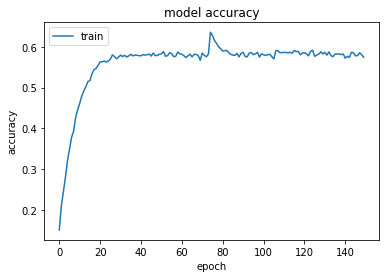

In [77]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

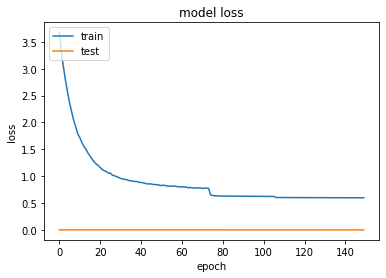

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['lr'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
# Importing the Libraries

from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer

model = load_model('nextword1.h5')
tokenizer = pickle.load(open('tokenizer1.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  for i in range(3):
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = np.array(sequence)
    
    preds = model.predict_classes(sequence)
#         print(preds)
    predicted_word = ""
    
    for key, value in tokenizer.word_index.items():
      if value == preds:
        predicted_word = key
        break
    
    #print(predicted_word)
  return predicted_word

In [ ]:
# EXAMPLES TO TYPE
# text1 = "at the dull"
# text2 = "collection of textile"
# text3 = "what a strenuous"
# text4 = "stop the script"

while(True):
  text = input("Enter your line: ")
    
  if text == "stop":
    print("Ending The Program.....")
    break
  
  else:
    try:
      text = text.split(" ")
      text = text[-1]

      text = ''.join(text)
      pred_word = Predict_Next_Words(model, tokenizer, text)
      print(pred_word)

          
    except:
      continue
